<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>


In [1]:
import gains as genetic
import pandas as pd
import rdkit
from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
import numpy as np
from math import exp
import random
import unittest
import datetime
%matplotlib inline

GAINS can use RDKit's similarity maps to evolve candidate structures toward a random target. the *cationInfo* library contains (currently) 300 cation structures—all of which can theoretically be used as either a starting structure or a target. The `genetic._mutation` function, however, is limited by a library of functional groups. I plan to expand this library in the future (as well as add crossover and selection functions) but for now I omit certain "special" imidazoles from the starting candidate structures.

c1cn(c([n+]1C))CC=C	0.5808080808080808	starting structure	0:00:00.003415
C[n+]1ccn(CC=O)c1	0.6421052631578947	replace_atom	0:00:00.023076
C[n+]1ccn(CC(N)=O)c1	0.7322175732217573	add_rdkit_fragment	0:00:00.166563
CCCCNC(=O)Cn1cc[n+](C)c1	0.9748953974895398	add_custom_fragment	0:00:00.326968
CCCCNC(=O)Cn1cc[n+](CC(N)=O)c1	1.0	add_rdkit_fragment	0:00:00.516291
number of atoms: 	15
mutation attempts: 	248


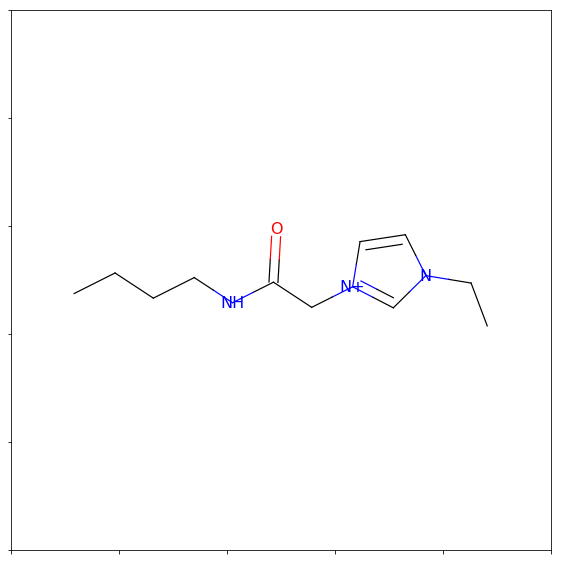

In [6]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = get_fitness(target, target)
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target, parent_candidates)
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation, timeDiff))
    
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])

def show_ion(genes, target, mutation_attempts):
    mol = Chem.MolFromSmiles(target)
    print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    

geneSet = genetic.generate_geneset()

df = genetic.load_data("cationInfo.csv")
df = df.loc[df["name"].str.contains("imid", case=False)]
df = df.loc[~df["name"].str.contains("phenyl", case=False)]
df = df.loc[~df["name"].str.contains("benzyl", case=False)]
df = df.loc[~df["name"].str.contains("azido", case=False)]
df = df.loc[~df["name"].str.contains("cyan", case=False)]
df = df.loc[~df["name"].str.contains("benz", case=False)]
df = df.loc[~df["name"].str.contains("cyclo", case=False)]
df = df.loc[~df["name"].str.contains("sulf", case=False)]
df = df.loc[~df["name"].str.contains("azepinium", case=False)]
parent_candidates = df['smiles'].unique()

df = parent_candidates
ohPickMe = random.sample(range(df.shape[0]),1)
target = df[ohPickMe[0]]
guess_password(target)
img = Draw.MolToMPL(Chem.MolFromSmiles(target))

Making slight changes to the above code, mainly involving the fitness function, we can use the genetic engine to search for structures of a desirable property. In this case we search for a **cation imidazole-type structure** paired with tetrafluroborate that gives a density of 800 kg/mol

0.8212894843777919
CCCCCCCCCCC[n+]1ccn(c1)C	0.8212894843777919	starting structure
CCCCC(O)CCCCCC[n+]1ccn(C)c1	0.955638012109044	add_rdkit_fragment
CCCC(O)CCCCCC[n+]1ccn(C)c1	0.972721176940531	remove_atom
CCCC(O)CCC(C)CCC[n+]1ccn(C)c1	0.9789310264483672	add_atom
CCCC(O)CCC(C)CC(C)C[n+]1ccn(C)c1	0.9976939822447748	add_atom
mutation attempts: 	53
within 1% of target density: 874 (kg/m) 


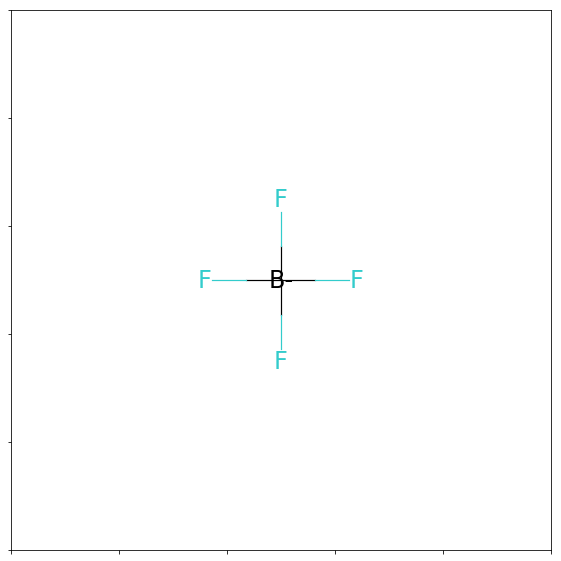

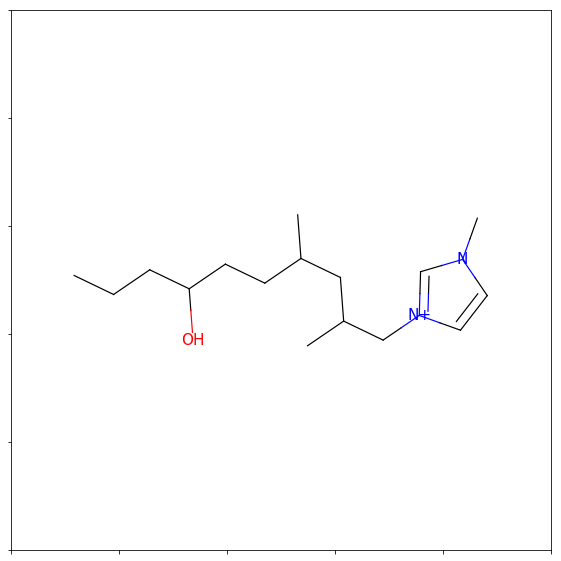

In [6]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = 0.99
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target)
    return best
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation))
    
def get_fitness(genes, target):
    cation = Chem.MolFromSmiles(genes)
    anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
    model = genetic.load_data("density_nn_model.sav", pickleFile=True)
    deslist = genetic.load_data("density_nn_model_descriptors.csv")
    feature_vector=[]
    with genetic.suppress_stdout_stderr():
        for item in deslist:
            if "anion" in item:
                feature_vector.append(calculator([item.partition('-')\
                    [0]]).CalcDescriptors(anion)[0])
            elif "cation" in item:
                feature_vector.append(calculator([item.partition('-')\
                [0]]).CalcDescriptors(cation)[0])          
            elif "Temperature_K" in item:
                feature_vector.append(298.15)
            elif "Pressure_kPa" in item:
                feature_vector.append(101.325)
            else:
                print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values
    prediction = exp(model.predict(np.array(features_normalized).reshape(1,-1))[0])
    error = abs((prediction-target)/target)
    
    return 1-error

def show_ion(genes, target, mutation_attempts):
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("within 1%% of target density: %s (kg/m) " % target)
    

geneSet = genetic.generate_geneset()
anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
target = random.sample(range(800,1500),1)[0]
best = guess_password(target)
an = Draw.MolToMPL(anion)
cat = Draw.MolToMPL(best.Mol)

But there's no need to be so picky! The engine can work for any range of density as long as its within the training data used to create the model (800-1500 kg/m3) and the same goes for the anion!

C([C@@H](C(=O)[O-])N)O
1463
C1=C[N+](C)=C(C)N1CCCCC	0.7336727732734313	starting structure
CCCC(P)Cn1cc[n+](C)c1C	0.7520025908024408	add_atom
CCCC(P)CN1C=C[N+]=C1C	0.8503636212737357	remove_atom
CCCC(P)C(Cl)N1C=C[N+]=C1C	0.9302790536241143	add_atom
CCCC(P)C(Cl)N1C=C[N+]=C1	0.9678310094428091	remove_atom
BC(CCC)C(Cl)N1C=C[N+]=C1	0.9702908203021559	replace_atom
BC(C)CC(B)C(Cl)N1C=C[N+]=C1	0.9753693817201333	add_atom
BC(CC(C)C)C(Cl)N1C=C[N+]=C1	0.9827475507773132	replace_atom
CC(C)CC(C)C(Cl)N1C=C[N+]=C1	0.9891577793598458	replace_atom
CCC(C(C)C)C(C)C(Cl)N1C=C[N+]=C1	0.989178216087152	add_custom_fragment
CC(C)C(C)C(C)C(Cl)N1C=C[N+]=C1	0.9994158659421755	remove_atom
mutation attempts: 	247
within 1% of target density: 1463 (kg/m) 


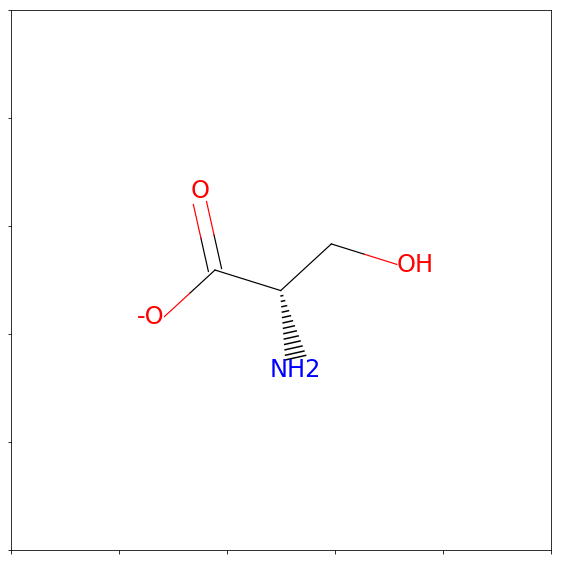

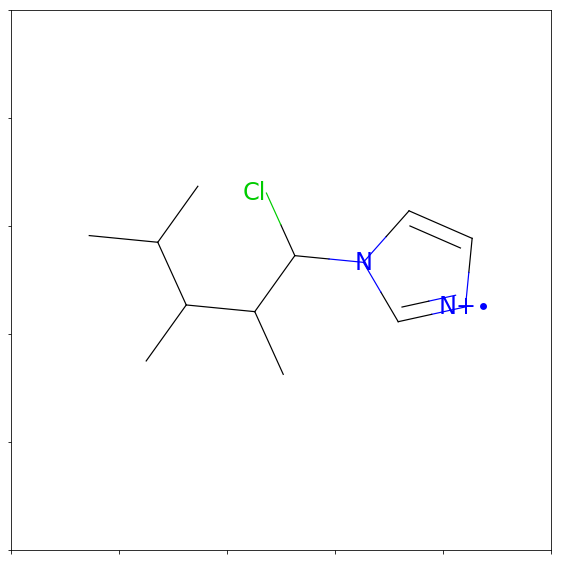

In [14]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(anion, genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = 0.99
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target, parent_candidates)
    return best
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation))
    
def get_fitness(anion, genes, target):
    cation = Chem.MolFromSmiles(genes)
    model = genetic.load_data("density_nn_model.sav", pickleFile=True)
    deslist = genetic.load_data("density_nn_model_descriptors.csv")
    feature_vector = []
    
    for item in deslist:

        if "anion" in item:
            with genetic.suppress_stdout_stderr():
                feature_vector.append(calculator([item.partition('-')\
                    [0]]).CalcDescriptors(anion)[0])
        elif "cation" in item:
            with genetic.suppress_stdout_stderr():
                feature_vector.append(calculator([item.partition('-')\
                [0]]).CalcDescriptors(cation)[0])          
        elif "Temperature_K" in item:
            feature_vector.append(298.15)
        elif "Pressure_kPa" in item:
            feature_vector.append(101.325)
        else:
            print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values
    prediction = exp(model.predict(np.array(features_normalized).reshape(1,-1))[0])
    error = abs((prediction-target)/target)
    
    return 1-error

def show_ion(genes, target, mutation_attempts):
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("within 1%% of target density: %s (kg/m) " % target)
    

geneSet = genetic.generate_geneset()

df = genetic.load_data("cationInfo.csv")
df = df.loc[df["name"].str.contains("imid", case=False)]
df = df.loc[~df["name"].str.contains("phenyl", case=False)]
df = df.loc[~df["name"].str.contains("benzyl", case=False)]
df = df.loc[~df["name"].str.contains("azido", case=False)]
df = df.loc[~df["name"].str.contains("cyan", case=False)]
df = df.loc[~df["name"].str.contains("benz", case=False)]
df = df.loc[~df["name"].str.contains("cyclo", case=False)]
df = df.loc[~df["name"].str.contains("sulf", case=False)]
df = df.loc[~df["name"].str.contains("azepinium", case=False)]
parent_candidates = df['smiles'].unique()


df = genetic.load_data("anionInfo.csv")
df = df['smiles'].unique()
ohPickMe = random.sample(range(df.shape[0]),1)
anion = Chem.MolFromSmiles(df[ohPickMe[0]])
print(df[ohPickMe[0]])
img = Draw.MolToMPL(anion)
target = random.sample(range(800,1500),1)[0]
print(target)
best = guess_password(target)
img = Draw.MolToMPL(best.Mol)